# Sharp Ratio & Frontier

In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

ds_yahoo = 'yahoo'

last_year = datetime.datetime.now().year - 1
start = datetime.datetime.now().replace(year=last_year)
end = datetime.datetime.now()

## Portfolio Atual

### Pegando os dados na API do Yahoo

In [2]:
tickers = ['ITUB4.SA', 'ABEV3.SA', 'USIM5.SA', 'PMAM3.SA', 'FLRY3.SA', 'PSSA3.SA', 'TIET4.SA']

itau = web.DataReader(tickers[0], ds_yahoo, start, end)
abev = web.DataReader(tickers[1], ds_yahoo, start, end)
usim = web.DataReader(tickers[2], ds_yahoo, start, end)
pmam = web.DataReader(tickers[3], ds_yahoo, start, end)
flry = web.DataReader(tickers[4], ds_yahoo, start, end)
pssa = web.DataReader(tickers[5], ds_yahoo, start, end)
tiet = web.DataReader(tickers[6], ds_yahoo, start, end)

## Normalizando o retorno diário de cada ativo do portfólio

In [3]:
for acao_df in (itau, abev, usim, pmam, flry, pssa, tiet):
    acao_df['Retorno Normalizado'] = acao_df['Adj Close'] / acao_df.iloc[0]['Adj Close']

## Alocando cada ativo com um peso específico

In [4]:
pesos = [.2851, .0954, .1230, .0372, .0657, .2724, .1213]

for acao_df, alocacao in zip((itau, abev, usim, pmam, flry, pssa, tiet), pesos):
    acao_df['Alocacao'] = acao_df['Retorno Normalizado'] * alocacao

## Posição de cada ativo no portfólio

In [5]:
for acao_df in (itau, abev, usim, pmam, flry, pssa, tiet):
    acao_df['Posicao'] = acao_df['Alocacao'] * 10000

In [6]:
todas_posicoes = [itau['Posicao'], abev['Posicao'], usim['Posicao'],
                  pmam['Posicao'], flry['Posicao'], pssa['Posicao'], tiet['Posicao']]

# DF que terá colunas adicionadas como Total e Retorno Diário
portfolio_posicao = pd.concat(todas_posicoes, axis=1)

# DF que terá apenas as ações com o Adj Close column
portfolio_acoes = pd.concat(todas_posicoes, axis=1)

In [7]:
portfolio_posicao.columns = ['ITUB', 'ABEV', 'USIM', 'PMAM', 'FLRY', 'PSSA', 'TIET']
portfolio_acoes.columns = ['ITUB', 'ABEV', 'USIM', 'PMAM', 'FLRY', 'PSSA', 'TIET']

## Desempenho da carteira

In [8]:
portfolio_posicao['Total'] = portfolio_posicao.sum(axis=1)

In [9]:
print('Investimento inicial:')
print(portfolio_posicao['Total'][0])
print('Investimento final:')
print(round(portfolio_posicao['Total'][-1], 2))

Investimento inicial:
10001.0
Investimento final:
13033.25


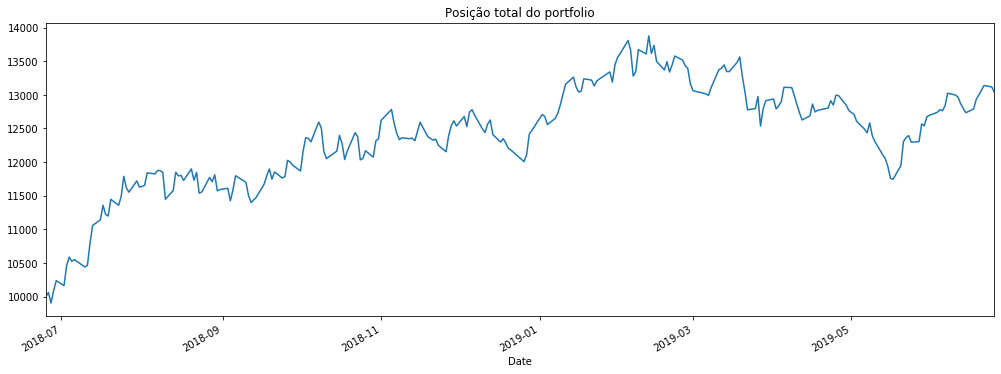

In [10]:
portfolio_posicao['Total'].plot(figsize=(17,6))
plt.title('Posição total do portfolio');

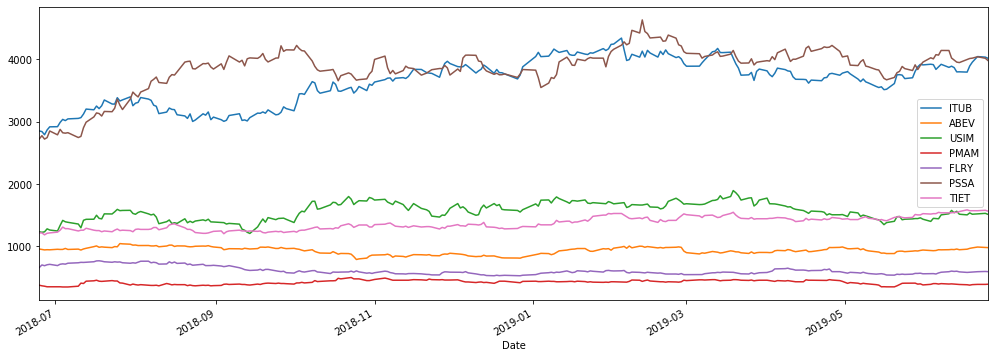

In [11]:
portfolio_acoes.plot(figsize=(17,6));

## Desempenho da Carteira Normalizada

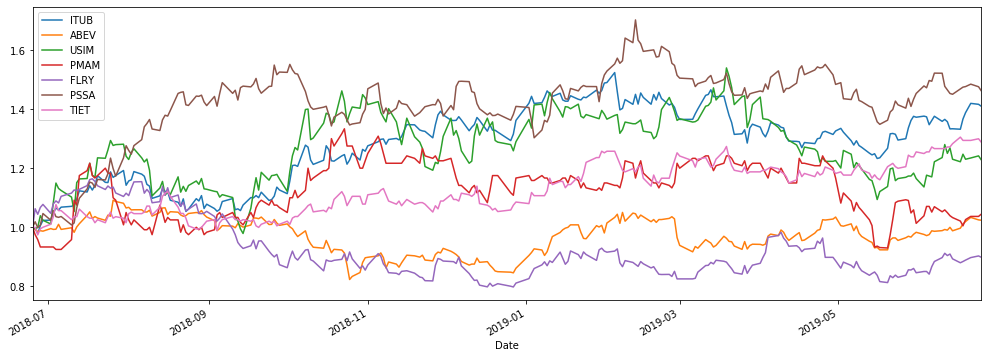

In [12]:
portfolio_normalizado = portfolio_acoes / portfolio_acoes.iloc[0]
portfolio_normalizado.plot(figsize=(17,6));

## Retorno diário da carteira

In [13]:
portfolio_posicao['Retorno Diario'] = portfolio_posicao['Total'].pct_change(1)

In [27]:
# Média de retorno diário
round_ret_medio_diario = round(portfolio_posicao['Retorno Diario'].mean() * 100, 2)
print('Essa carteira rende em média {}% diariamente'.format(round_ret_medio_diario))

Essa carteira rende em média 0.12% diariamente


In [15]:
# Desvio Padrão do retorno diário
portfolio_posicao['Retorno Diario'].std()

0.01246381403560676

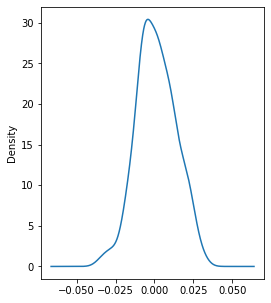

In [16]:
# Gráfico de densidade
portfolio_posicao['Retorno Diario'].plot(kind='kde', figsize=(4,5));

## Retorno Total da Carteira

In [17]:
retorno_total_acumulado = 100 * (portfolio_posicao['Total'][-1] / portfolio_posicao['Total'][0] - 1)
round_ret = round(retorno_total_acumulado, 3)
print('Essa carteira rendeu {} %'.format(round_ret))

Essa carteira rendeu 30.32 %


In [18]:
sharpe_ratio = (portfolio_posicao['Retorno Diario'].mean()) / portfolio_posicao['Retorno Diario'].std()
sharpe_ratio

0.09296962397551223

In [19]:
sharpe_ratio_ano = (245 ** 0.5) * sharpe_ratio
sharpe_ratio_ano

1.4552047933628771

## Retorno diário

In [20]:
retorno_diario = portfolio_acoes.pct_change(1)

## Gerando um único portfólio com posição atual

In [21]:
print(portfolio_acoes.columns)

# Gerando pesos aleatórios
print("Pesos Atuais")
print(pesos)

print("Rebalancear os pesos")
pesos = pesos / np.sum(pesos)
print(pesos)

# Retorno esperado
print("Retorno esperado")
ret_esp = np.sum( (retorno_diario.mean() * pesos) * 245 )
print(ret_esp)

# Volatilidade esperada
print("Volatilidade esperada")
vol_esp = np.sqrt( np.dot( pesos.T, np.dot( retorno_diario.cov() * 245, pesos ) ) )
print(vol_esp)

# Taxa de Sharpe
print("Sharpe Ratio")
sharpe = (ret_esp - 0.065) / vol_esp
print(sharpe)


Index(['ITUB', 'ABEV', 'USIM', 'PMAM', 'FLRY', 'PSSA', 'TIET'], dtype='object')
Pesos Atuais
[0.2851, 0.0954, 0.123, 0.0372, 0.0657, 0.2724, 0.1213]
Rebalancear os pesos
[0.28507149 0.09539046 0.1229877  0.03719628 0.06569343 0.27237276
 0.12128787]
Retorno esperado
0.30374883761068505
Volatilidade esperada
0.1932933402578886
Sharpe Ratio
1.235163287530499


## Gerando milhares de portfólios

In [22]:
num_portfolios = 50000
pesos_arr = np.zeros((num_portfolios, len(portfolio_acoes.columns)))
ret_esp_arr = np.zeros(num_portfolios)
vol_esp_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for ind in range(num_portfolios):

    # Pesos aleatórios
    pesos = np.array(np.random.random(7))
    pesos = pesos / np.sum(pesos)
    pesos_arr[ind,:] = pesos

    # Retorno esperado
    ret_esp_arr[ind] = np.sum( (retorno_diario.mean() * pesos) * 245 )

    # Volatilidade esperada
    vol_esp_arr[ind] = np.sqrt( np.dot( pesos.T, np.dot( retorno_diario.cov() * 245, pesos ) ) )

    # Taxa de Sharpe
    sharpe_arr[ind] = (ret_esp_arr[ind] - 0.065) / vol_esp_arr[ind]

pesos_arr[sharpe_arr.argmax(),:]

array([0.32492868, 0.00764669, 0.05838742, 0.05361701, 0.01495727,
       0.29189387, 0.24856906])

In [23]:
sharpe_arr.max()

1.4742347993017522

In [24]:
sharpe_arr.argmax()

5468

In [25]:
pesos_arr[sharpe_arr.argmax(),:]

array([0.32492868, 0.00764669, 0.05838742, 0.05361701, 0.01495727,
       0.29189387, 0.24856906])

### Gerando CSV

In [26]:
itau.to_csv('csv/ITUB4.csv')
abev.to_csv('csv/ABEV3.csv')
usim.to_csv('csv/USIM5.csv')
pmam.to_csv('csv/PMAM3.csv')
flry.to_csv('csv/FLRY3.csv')
pssa.to_csv('csv/PSSA3.csv')
tiet.to_csv('csv/TIET4.csv')